In [175]:
from datetime import datetime
import os
import itertools
from pathlib import Path
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import torch
from tqdm import tqdm

from darts import TimeSeries
from darts.dataprocessing.transformers import StaticCovariatesTransformer
from darts.dataprocessing.transformers.scaler import Scaler
from darts.models import TiDEModel
from darts.metrics import mae, mse
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

%matplotlib inline

In [176]:
class Config:
    seed = 2023
    timestamp = datetime.now().strftime('%Y%m%d%H%M%S')
    curr_dirpath = Path(os.getcwd())
    repo_dirpath = curr_dirpath / '../'
    dataset_dirpath = repo_dirpath / 'input'
    ts_identifier_col = 'store_item'
    ts_col = 'date'
    target_col = 'sales'

config = Config()

In [177]:
train_df = pd.read_csv(config.dataset_dirpath / "train.csv")
# train_df = train_df.reset_index()

print(train_df.shape)
train_df.head()

(913000, 4)


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [178]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [179]:
"""
Check for duplicate rows
"""
count_duplicate_rows = len(train_df)-len(train_df.drop_duplicates())
print(f"There are {count_duplicate_rows} duplicate rows")

There are 0 duplicate rows


In [180]:
"""
Reduce the amount of data for simplicity
"""
train_df = train_df.loc[train_df["store"] <= 2]

In [181]:
train_df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [182]:
"""
Create a new column by concatenating "store" and "item" columns

Note
----
pandas: 14 sec
"""
train_df["store_item"] = train_df.apply(lambda row: f"{row['store']}_{row['item']}", axis=1)
train_df.head(1)

,date,store,item,sales,store_item
0,2013-01-01,1,1,13,1_1


In [183]:
"""
Convert `date` column to datetime
"""
train_df['date'] = pd.to_datetime(train_df['date'])

In [184]:
"""
Calculate total sales per date for store and item
"""
groups = train_df.groupby(['date', 'store_item'])
df = groups['sales'].aggregate('sum').reset_index()
df = df.sort_values(['date', 'store_item'], ascending=True)

df.head()

,date,store_item,sales
0,2013-01-01,1_1,13
1,2013-01-01,1_10,37
2,2013-01-01,1_11,37
3,2013-01-01,1_12,33
4,2013-01-01,1_13,37


Not all items sell every day
- For each "store_item" value add all the missing "date" values and fill in "sales" with 0s

In [185]:
"""
Generate an index with all combinations of "date" and "store_item" values
"""
multiindex: List[Tuple[pd.Timestamp, str]] = list(zip(df["date"], df["store_item"]))
multiindex = pd.MultiIndex.from_tuples(multiindex, names=('index_1', 'index_2'))
print(multiindex[0:3])

MultiIndex([('2013-01-01',  '1_1'),
            ('2013-01-01', '1_10'),
            ('2013-01-01', '1_11')],
           names=['index_1', 'index_2'])


In [186]:
df.index = multiindex
display(df.head(1))

,,date,store_item,sales
index_1,index_2,,,
2013-01-01,1_1,2013-01-01,1_1,13


In [187]:
idx_dates = list(pd.date_range(min(df["date"]), max(df["date"])))
idx_ids = list(df["store_item"].unique())

idx = list(itertools.product(idx_dates, idx_ids))
print(idx[0:3])

[(Timestamp('2013-01-01 00:00:00'), '1_1'), (Timestamp('2013-01-01 00:00:00'), '1_10'), (Timestamp('2013-01-01 00:00:00'), '1_11')]


In [188]:
df = df.reindex(idx, fill_value=0).reset_index()
df.head(1)

,index_1,index_2,date,store_item,sales
0,2013-01-01,1_1,2013-01-01,1_1,13


In [189]:
df.isnull().sum()

index_1       0
index_2       0
date          0
store_item    0
sales         0
dtype: int64

In [190]:
df.reset_index(drop=True, inplace=True)
del df['index_1']
del df['index_2']
df.head(1)

,date,store_item,sales
0,2013-01-01,1_1,13


Feature Engineering

In [191]:
def feature_engineering(df):
    df['store'] = df['store_item'].apply(lambda x: int(x.split('_')[0]))
    df['item'] = df['store_item'].apply(lambda x: int(x.split('_')[1]))

    return df

In [192]:
df = feature_engineering(df)
display(df.head(2))

,date,store_item,sales,store,item
0,2013-01-01,1_1,13,1,1
1,2013-01-01,1_10,37,1,10


Farecasing Model

In [193]:
print(f"{df['date'].min()} --> {df['date'].max()}")

2013-01-01 00:00:00 --> 2017-12-31 00:00:00


In [194]:
static_cov_col_list: List[str] = [
    'store',
    'item',
]
past_cov_col_list: List[str] = []
future_cov_col_list: List[str] = []

In [195]:
"""
Prepare TimeSeries for Darts

Note
----
time_col: str: timeseries column name
group_cols, List[str]: individual time series are extracted by grouping `df` by `group_cols`
static_cols, List[str]: extract these additional columns as static covariates (without grouping)
values_cols, List[str]: timeseries value column name list
"""
series: List = TimeSeries.from_group_dataframe(
    df,
    time_col=config.ts_col,
    group_cols=config.ts_identifier_col,
    static_cols=static_cov_col_list,
    value_cols=[config.target_col],
    freq='D',
    fill_missing_dates=True,
)

In [196]:
# static cov
series[0].static_covariates

static_covariates,store_item,store,item
component,,,
sales,1_1,1.0,1.0


In [197]:
"""
Scaling/Encoding/Transforming static covariate data
"""
transformer = StaticCovariatesTransformer()
series = transformer.fit_transform(series)

# static cov
series[2].static_covariates

static_covariates,store_item,store,item
component,,,
sales,2.0,0.0,0.204082


In [198]:
"""
Scaling non-static data

Note:
scaling MUST be separately for target series and past covariate series
"""
scaler = Scaler()
series = scaler.fit_transform(series)

# static cov
series[2].static_covariates


static_covariates,store_item,store,item
component,,,
sales,2.0,0.0,0.204082


In [199]:
"""
Split the dataset
"""
ts_separator_train2val = pd.Timestamp('2016-01-01')
ts_separator_val2test = pd.Timestamp('2017-01-01')

train_series, val_series, test_series = [], [], []
for _series in series:
    _train_series, _val_series = _series.split_before(ts_separator_train2val)
    _val_series, _test_series = _val_series.split_before(ts_separator_val2test)
    train_series.append(_train_series)
    val_series.append(_val_series)
    test_series.append(_test_series)

In [200]:
# display(train_series[0][0].pd_dataframe())
# display(train_series[0][-1].pd_dataframe())
# display(val_series[0][0].pd_dataframe())
# display(val_series[0][-1].pd_dataframe())
# display(test_series[0][0].pd_dataframe())
# display(test_series[0][-1].pd_dataframe())

In [201]:
"""
Hyper params for TiDE
"""
optimizer_kwargs = {
    "lr": 1e-4,
}

# PyTorch Lightning Trainer arguments
pl_trainer_kwargs = {
    "gradient_clip_val": 1,
    "max_epochs": 1000,  # 200
    "accelerator": "cpu",  # default="auto", "gpu", "cpu"
    "callbacks": [],
}

# learning rate scheduler
lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
lr_scheduler_kwargs = {
    "gamma": 0.999,
}

# early stopping (needs to be reset for each model later on)
# this setting stops training once the the validation loss has not decreased by more than 1e-3 for 10 epochs
early_stopping_args = {
    "monitor": "val_loss",
    "patience": 40,  # 10
    "min_delta": 1e-3,
    "mode": "min",
}

#
common_model_args = {
    "input_chunk_length": 12,  # context window/lookback window
    "output_chunk_length": 1,  # forecast horizon/lookahead window
    "optimizer_kwargs": optimizer_kwargs,
    "pl_trainer_kwargs": pl_trainer_kwargs,
    "lr_scheduler_cls": lr_scheduler_cls,
    "lr_scheduler_kwargs": lr_scheduler_kwargs,
    "likelihood": None,  # use a likelihood for probabilistic forecasts
    "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
    "force_reset": True,
    "batch_size": 256,
    "random_state": config.seed,
}

In [202]:
n_timeseries = 5

# Initialize a model instance
model = TiDEModel(
    **common_model_args,
    model_name='sales_forecasting',
    use_reversible_instance_norm=False,
    use_static_covariates=True,
)

# early stopping needs to get reset for each model
pl_trainer_kwargs["callbacks"] = [
    EarlyStopping(
        **early_stopping_args,
    )
]

# training
model.fit(
    series=train_series[:n_timeseries],
    val_series=val_series[:n_timeseries],
    # past_covariates=past_cov_series,
    # val_past_covariates=past_cov_series,
    # future_covariates=past_cov_series,
    # val_future_covariates=past_cov_series,
    verbose=False,
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sho/git-portfolio/sales_forecast_walmart/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
`Trainer.fit` stopped: `max_epochs=1000` reached.


TiDEModel(num_encoder_layers=1, num_decoder_layers=1, decoder_output_dim=16, hidden_size=128, temporal_width_past=4, temporal_width_future=4, temporal_decoder_hidden=32, use_layer_norm=False, dropout=0.1, use_static_covariates=True, input_chunk_length=12, output_chunk_length=1, optimizer_kwargs={'lr': 0.0001}, pl_trainer_kwargs={'gradient_clip_val': 1, 'max_epochs': 1000, 'accelerator': 'cpu', 'callbacks': []}, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ExponentialLR'>, lr_scheduler_kwargs={'gamma': 0.999}, likelihood=None, save_checkpoints=True, force_reset=True, batch_size=256, random_state=2023, model_name=sales_forecasting, use_reversible_instance_norm=False)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sho/git-portfolio/sales_forecast_walmart/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.16it/s]


0it [00:00, ?it/s]

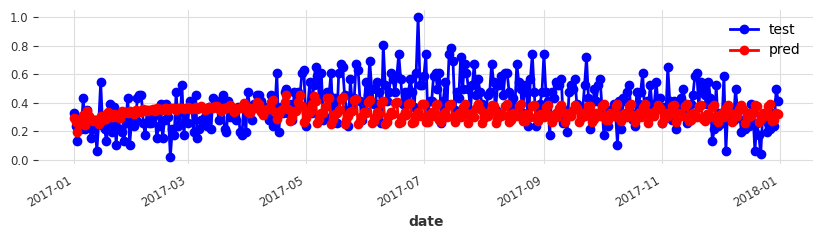

1it [00:00,  7.10it/s]

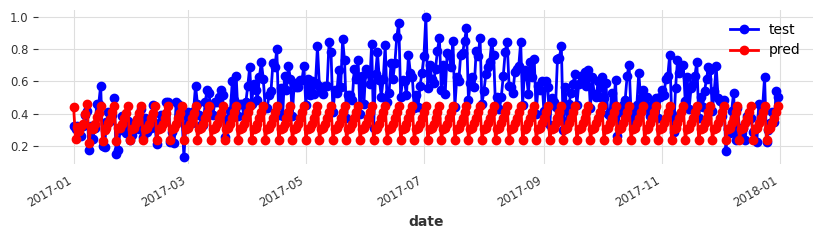

2it [00:00,  7.07it/s]

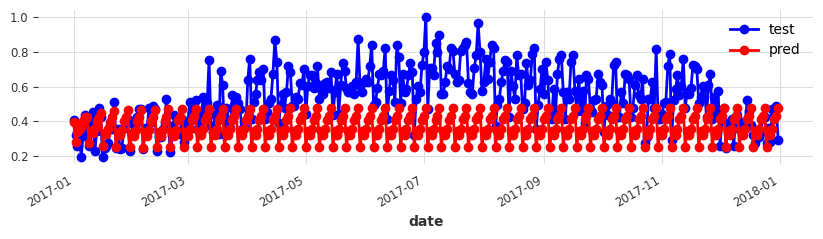

3it [00:00,  7.09it/s]

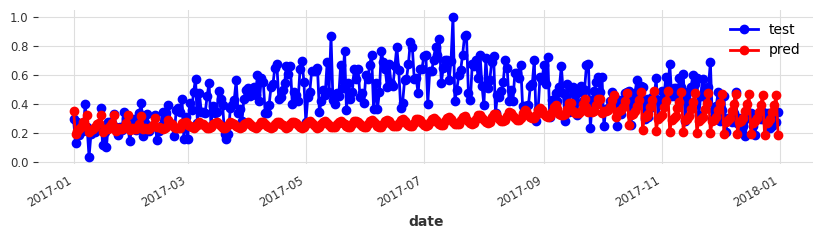

4it [00:00,  6.99it/s]

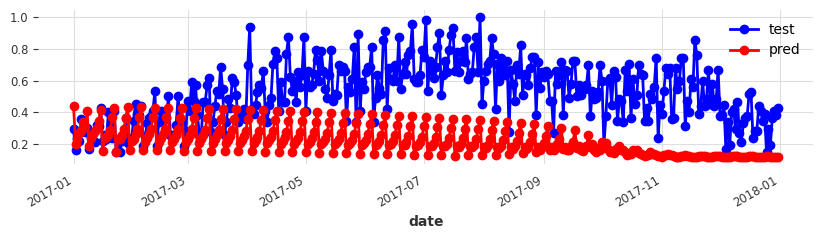

5it [00:00,  7.04it/s]


In [211]:
"""
Prediction
"""
pred_series = model.predict(
    n=365,
    series=val_series,
    # past_covariates=past_cov_test,
    # future_covariates=past_cov_test,
)

# visualization
for _test_series, _pred_series in tqdm(zip(test_series[:n_timeseries], pred_series[:n_timeseries])):
    fig = plt.figure(figsize=(10, 2))
    _test_series.plot(label='test', color='b', marker='o')
    _pred_series.plot(label='pred', color='r', marker='o')
    plt.show()